In [1]:
import yaml
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        < 0.1
    )
    period_check = np.abs(period - true_period) < 0.01
    period_check |= np.abs(2 * period - true_period) < 0.01
    period_check |= np.abs(period / 2 - true_period) < 0.01
    same = period_check  # np.logical_and(t0_check, period_check)
    if verbose:
        if not same:
            if not t0_check:
                output = f"t0 differ: {t0:.2e} {true_t0:.2e}"
            if not period_check:
                output = f"period differ: {period:.2e} {true_period:.2e}"
        else:
            output = "match"
        return same, output
    else:
        return same


def get_result(f):
    d = yaml.safe_load(open(f, "r"))
    return (
        d["planet_period"],
        d["planet_radius"],
        right_candidate(
            d["found_t0"], d["found_period"], d["transit_t0"], d["planet_period"]
        ),
    )

In [70]:
from nuance.kernels import rotation
from nuance.star import Star
import pickle

tic = 452793374

data = pickle.load(open(f"../data/{tic}/cleaned_lc.fluxes", "rb"))
star = Star(
    data["star_radius"], data["star_mass"], data["star_amplitude"], data["star_period"]
)
gp_file = f"../data/{tic}/gp.yaml"
gp_params = yaml.full_load(open(gp_file, "r"))
build_gp, _ = rotation(data["star_period"])
gp = build_gp(gp_params, data["time"])


In [71]:
from nuance.star import R_EARTH
from nuance.utils import phase


def min_radius_red(self, period, SNR, dt, N, sigma, sigma_r):
    duration = self.transit_duration(period)
    n_tr = N * duration / period  # points in transit
    N_tr = N * dt / period  # transits in the data
    sr = (sigma_r**2) / N_tr
    sw = (sigma**2) / n_tr
    s = np.sqrt(sr + sw)
    return (np.sqrt(SNR * s) * self.radius) / R_EARTH

ValueError: not enough values to unpack (expected 3, got 0)

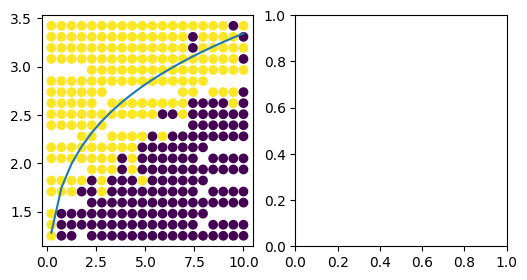

In [72]:
plt.figure(None, (6, 3))
ax = plt.subplot(121)
period, radii, n_detected = np.array(
    [get_result(f) for f in glob(f"../data/{tic}/nuance_search/*")]
).T
plt.scatter(period, radii, c=n_detected, vmin=0, vmax=1)
ylim = plt.ylim()
xlim = plt.xlim()

unique_periods = np.unique(period)
sigma = np.exp(gp_params["log_jitter"])
sigma_r = np.exp(gp_params["log_short_sigma"]) + np.exp(gp_params["log_long_sigma"])
dt = np.median(np.diff(data["time"]))
N = len(data["time"])
min_radii = min_radius_red(star, unique_periods, 5, dt, N, sigma, sigma_r)
plt.xlim(xlim)
plt.ylim(ylim)
plt.plot(unique_periods, min_radii)
# plt.plot(unique_periods, min_radii2)

ax = plt.subplot(122)
files = glob(f"../data/{tic}/tls_search/*")
period, radii, t_detected = np.array([get_result(f) for f in files]).T

plt.scatter(period, radii, c=t_detected, vmin=0, vmax=1)
plt.ylim(ylim)
xlim = plt.xlim(xlim)

In [25]:
sigma_r = np.exp(gp_params["log_short_sigma"])


In [27]:
np.exp(gp_params["log_long_sigma"])


0.004293702281757891

In [17]:
min_radii = np.array(
    [min_radius_red(star, p, 5, data["time"], gp, sigma) for p in unique_periods]
)

TypeError: min_radius_red() missing 1 required positional argument: 'sigma_r'

In [33]:
np.array([get_result(f) for f in files]).T


array([], dtype=float64)

In [6]:
files[np.argmin(np.abs(period - 5))]

'../data/29923559/tls_search/289.yaml'

In [6]:
np.count_nonzero(n_detected) / len(n_detected)


0.631578947368421

In [7]:
np.count_nonzero(t_detected) / len(t_detected)


0.3783783783783784

KeyError: 't0'

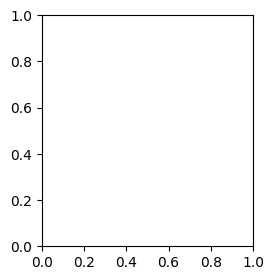

In [17]:
import matplotlib.pyplot as plt

tic = 29923559


def get_result(f):
    d = yaml.safe_load(open(f, "r"))
    return (
        d["tau"],
        d["delta"],
        right_candidate(d["t0"], d["period"], d["true_t0"], d["true_period"]),
    )


plt.figure(None, (6, 3))
ax = plt.subplot(121)
n_tau, n_delta, n_detected = np.array(
    [get_result(f) for f in glob(f"../data/{tic}/nuance_search/*")]
).T
plt.scatter(n_tau, n_delta, c=n_detected)
ylim = plt.ylim()
xlim = plt.xlim()
secax = ax.secondary_xaxis("top")
taus = np.min(n_tau), np.max(n_tau)
secax.set_xticks(taus, [f"{p:.1f}" for p in tau2period(taus)])
secax.set_xlabel("period (days)")
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\delta$")

ax = plt.subplot(122)
t_tau, t_delta, t_detected = np.array(
    [get_result(f) for f in glob(f"../data/{tic}/tls_search/*")]
).T
plt.scatter(t_tau, t_delta, c=t_detected)
plt.ylim(ylim)
plt.xlim(xlim)
secax = ax.secondary_xaxis("top")
secax.set_xlabel("period (days)")
taus = np.min(n_tau), np.max(n_tau)
secax.set_xticks(taus, [f"{p:.1f}" for p in tau2period(taus)])
secax = ax.secondary_yaxis("right")
deltas = np.min(t_delta), np.max(t_delta)
ax.yaxis.set_visible(False)
secax.set_yticks(deltas, [f"{p:.1f}" for p in delta2radius(deltas)])
secax.set_ylabel(r"radius ($R_\oplus$)")
ax.set_xlabel(r"$\tau$")

plt.tight_layout()

In [171]:
from nuance.utils import convert_parameters
import pickle

data = pickle.load(open("../data/140212114/lc.fluxes", "rb"))
tau_delta, period_radius, snr = convert_parameters(
    data["star_radius"], data["star_mass"], data["amplitude"], data["period"]
)
data = pickle.load(open("../data/140212114/params.values", "rb"))


In [97]:
from functools import partial


@partial(np.vectorize, signature="()->()")
def tau2period(tau):
    return period_radius(tau, -1)[0]


@partial(np.vectorize, signature="()->()")
def delta2radius(delta):
    return period_radius(-1, delta)[1]


In [134]:
import pickle

(data,) = pickle.load(open("../data/140212114/params.values", "rb"))


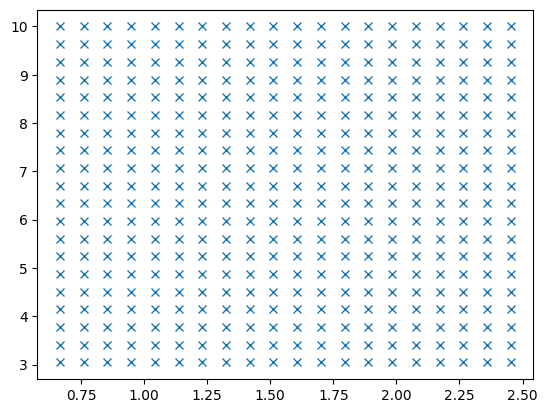

In [153]:
plt.plot(*data, "x")

In [5]:
import pandas as pd

tau, delta, detected_nuance = np.array(
    [get_result(f) for f in glob("../data/140212114/nuance_search/*")]
).T
tau, delta, detected_tls = np.array(
    [get_result(f) for f in glob("../data/140212114/tls_search/*")]
).T

df = pd.DataFrame(
    {"tau": tau, "delta": delta, "nuance": detected_nuance, "tls": detected_tls}
)


NameError: name 'get_result' is not defined

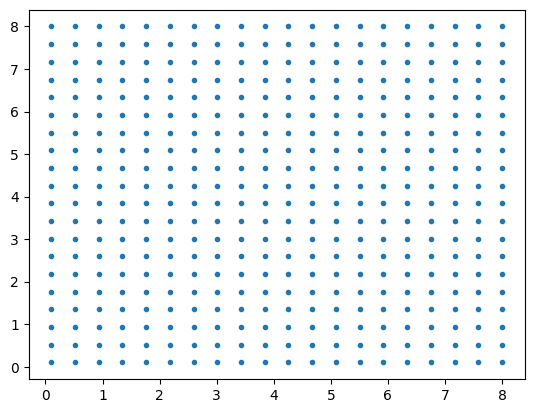

In [118]:
x, y = np.meshgrid(np.linspace(0.1, 8, 20), np.linspace(0.1, 8, 20))
plt.plot(x.flatten(), y.flatten(), ".")

In [117]:
30 * 30


900

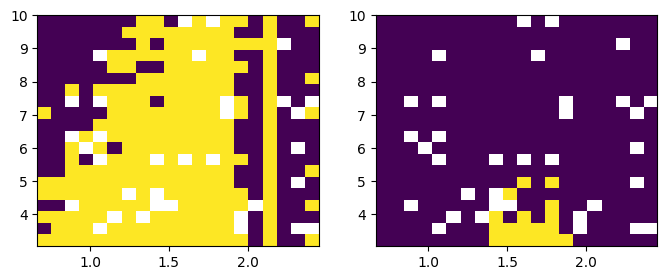

In [185]:
from scipy.stats import binned_statistic_2d


def show(x, y, z, bins=(20, 20)):
    stats = binned_statistic_2d(x, y, z, bins=bins)
    im = plt.imshow(
        stats.statistic.T,
        origin="lower",
        extent=(
            stats.x_edge.min(),
            stats.x_edge.max(),
            stats.y_edge.min(),
            stats.y_edge.max(),
        ),
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
    )


plt.figure(None, (8, 3))
plt.subplot(121)
show(n_tau, n_delta, n_detected)
plt.subplot(122)
show(t_tau, t_delta, t_detected)


In [149]:
import numpy as np

# Define the size of the grid and the number of points
grid_size = 100
num_points = 500

# Generate the Fibonacci sequence up to the number of points
n = int(num_points * (1 + np.sqrt(5)) / 2)  # use golden ratio for spacing
fibonacci = [1, 1]
while len(fibonacci) < n:
    next_fibonacci = fibonacci[-1] + fibonacci[-2]
    fibonacci.append(next_fibonacci)

# Normalize the sequence to fit within the grid size
max_fibonacci = max(fibonacci)
fibonacci = [f * (grid_size - 1) / max_fibonacci for f in fibonacci]

# Define the center of the grid
center_x, center_y = grid_size / 2, grid_size / 2

# Generate a grid of points using the Fibonacci lattice
points = []
for i in range(num_points):
    r = fibonacci[i]
    theta = 2 * np.pi * i / (np.sqrt(5) + 1)
    x = r * np.cos(theta) + center_x
    y = r * np.sin(theta) + center_y
    points.append((x, y))

# Print the list of points
print(points)

# Print the list of points
# plt.plot(*np.array(points).T, "x")


[(50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0, 50.0), (50.0

In [147]:
points

[(50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),
 (50, 50),